In [33]:
import pandas as pd
import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


filepath = u"./data/resume_sentence_dataset_balanced.csv"

data = pd.read_csv(filepath)
data = data.dropna()
data

,Sentence #,Word,Tag
0,0,Govardhana,Name
1,0,K,Name
2,0,Senior,Profil
3,0,Software,Profil
4,0,Engineer,Profil
...,...,...,...
720759,28831,2013,Date
720760,28831,2013,Date
720761,28831,2010,Date
720762,28831,2015,Date


In [2]:
#change date tag to Date instead of 0
#data.loc[data.index[data.Word.str.contains("[0-9]{4}$")],'Tag'] = "Date"

In [117]:
data["Tag"].value_counts()

Email Address          65524
O                      65524
Profil                 65524
Date                   65524
Companies worked at    65524
Location               65524
Degree                 65524
Duration               65524
College Name           65524
Skills                 65524
Name                   65524
Name: Tag, dtype: int64

In [4]:
## remove random O-Tag
#import random
import math

index = data.index[data['Tag'] == "O"]
O_tagSize = math.ceil((len(index)*0.9))

drop_indices = np.random.choice(index, O_tagSize, replace=False)
#data = data.drop(drop_indices)

data["Tag"].value_counts()

Email Address          65524
O                      65524
Profil                 65524
Date                   65524
Companies worked at    65524
Location               65524
Degree                 65524
Duration               65524
College Name           65524
Skills                 65524
Name                   65524
Name: Tag, dtype: int64

In [2]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

14730

In [3]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

11

In [4]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            print(s)
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)

In [5]:
sentences = getter.sentences

In [6]:
#pad word to a length of 50 (why ? Keras need to have same length for each input in the neural net)
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[1]] for w in s] for s in sentences]


X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=0)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post",value=0)

In [8]:
from tensorflow import keras
# change label to categorical
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

#X = X.reshape(X.shape[0],X.shape[1],1)
#y = y.reshape(y.shape[0],y.shape[1],1)
#X.shape,y.shape

In [9]:
# split dataset into train (input & label) test (input & label)
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
len(y_tr)

25947

In [10]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=50, input_shape=(max_len,), input_length=max_len,mask_zero=True))# 50-dim embedding
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.5)))  # variational biLSTM
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))  # softmax output layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            736500    
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           58880     
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 11)            1419      
Total params: 796,799
Trainable params: 796,799
Non-trainable params: 0
_________________________________________________________________


In [11]:
%load_ext tensorboard
import tensorflow as tf
import datetime

!del /Q logs 

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:

history = model.fit(X_tr, np.array(y_tr), batch_size=256, epochs=5, validation_split=0.3, callbacks=[tensorboard_callback], verbose=1,shuffle=True)

Train on 18162 samples, validate on 7785 samples
Epoch 1/5
18162/18162 [==============================] - 39s 2ms/sample - loss: 0.7407 - accuracy: 0.5621 - val_loss: 0.3581 - val_accuracy: 0.7897
Epoch 2/5
18162/18162 [==============================] - 33s 2ms/sample - loss: 0.2968 - accuracy: 0.8205 - val_loss: 0.1550 - val_accuracy: 0.9471
Epoch 3/5
18162/18162 [==============================] - 39s 2ms/sample - loss: 0.1361 - accuracy: 0.9290 - val_loss: 0.0709 - val_accuracy: 0.9699
Epoch 4/5
18162/18162 [==============================] - 38s 2ms/sample - loss: 0.0649 - accuracy: 0.9694 - val_loss: 0.0392 - val_accuracy: 0.9817
Epoch 5/5
18162/18162 [==============================] - 31s 2ms/sample - loss: 0.0352 - accuracy: 0.9837 - val_loss: 0.0295 - val_accuracy: 0.9844


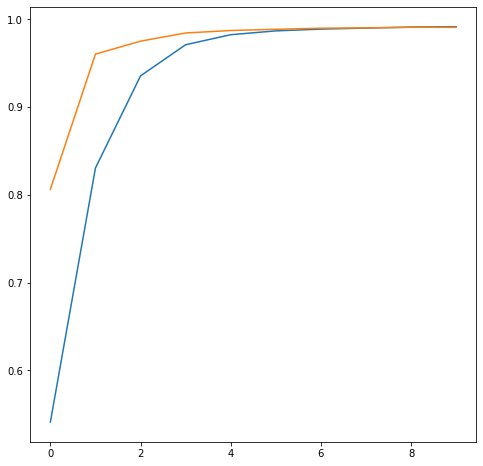

In [70]:
import matplotlib.pyplot as plt
hist = pd.DataFrame(history.history)
plt.figure(figsize = (8, 8))
plt.plot(hist["accuracy"],label="accuracy")
plt.plot(hist["val_accuracy"],label="validation_acc")
plt.show()

In [14]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

2884/2884 [==============================] - 2s 792us/sample
F1-score: 28.2%
                     precision    recall  f1-score   support

      Email Address       0.08      0.98      0.16      6825
             Skills       0.94      0.98      0.96      6595
             Profil       0.00      0.00      0.00      2926
               Name       0.93      0.92      0.92       276
             Degree       0.93      0.90      0.92       283
Companies worked at       0.96      0.86      0.91       283
               Date       0.99      0.93      0.96       285
           Location       1.00      0.91      0.95       302
           Duration       0.97      0.98      0.98       260
       College Name       0.97      0.89      0.93       295

          micro avg       0.17      0.82      0.28     18330
          macro avg       0.48      0.82      0.51     18330



In [32]:
i = 654
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
2.Targeting    : Profil
Technical      : Profil
Software       : Profil
Manager        : Profil
Sec.           : Profil
Project        : Profil
in             : Profil
scoping        : Profil
Test           : Profil
Software       : Profil
complaints.    : Profil
SAP            : Profil
Engineer       : Profil
Delivery       : Profil
sessions.      : Profil
Consultant     : Profil
Operator       : Profil
mission        : Profil
competencies.  : Profil
Consultant     : Profil
Technical      : Profil
Protected      : Profil
Engineer       : Profil
Test           : Profil
Connection     : Profil
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.           : O
out.     

In [17]:
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_tr]
value = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
print(value)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

[1.00204681 0.99528193 1.00247267 1.00204681 1.00417973 0.99907589
 1.00162131 0.99612254 0.99235094 0.99907589 1.00589261]


In [18]:
history = model.fit(X_tr, np.array(y_tr), batch_size=256, epochs=10, shuffle=True,validation_split=0.1, verbose=1,class_weight=value)

Train on 23352 samples, validate on 2595 samples
Epoch 1/10
23352/23352 [==============================] - 47s 2ms/sample - loss: 0.0258 - accuracy: 0.9870 - val_loss: 0.0267 - val_accuracy: 0.9861
Epoch 2/10
23352/23352 [==============================] - 38s 2ms/sample - loss: 0.0192 - accuracy: 0.9900 - val_loss: 0.0251 - val_accuracy: 0.9867
Epoch 3/10
23352/23352 [==============================] - 37s 2ms/sample - loss: 0.0165 - accuracy: 0.9912 - val_loss: 0.0232 - val_accuracy: 0.9877
Epoch 4/10
23352/23352 [==============================] - 38s 2ms/sample - loss: 0.0146 - accuracy: 0.9918 - val_loss: 0.0222 - val_accuracy: 0.9877
Epoch 5/10
23352/23352 [==============================] - 38s 2ms/sample - loss: 0.0129 - accuracy: 0.9924 - val_loss: 0.0218 - val_accuracy: 0.9880
Epoch 6/10
23352/23352 [==============================] - 38s 2ms/sample - loss: 0.0118 - accuracy: 0.9931 - val_loss: 0.0216 - val_accuracy: 0.9883
Epoch 7/10
23352/23352 [==============================] -

In [19]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

2884/2884 [==============================] - 2s 786us/sample
F1-score: 88.4%
                     precision    recall  f1-score   support

      Email Address       1.00      0.98      0.99      6825
             Skills       0.96      0.99      0.97      6595
             Profil       0.04      0.00      0.01      2926
               Name       0.88      0.94      0.91       276
             Degree       0.90      0.93      0.91       283
Companies worked at       0.89      0.90      0.90       283
               Date       0.97      0.93      0.95       285
           Location       0.99      0.98      0.98       302
           Duration       0.98      0.98      0.98       260
       College Name       0.92      0.91      0.91       295

          micro avg       0.95      0.82      0.88     18330
          macro avg       0.82      0.82      0.82     18330



In [20]:
test_sentence = ["Developer" ,"in", "HTML5", ",", "JavaScript", "and", "CSS3", "(Examen 70-480)"
                ,"Oracle", ".","Developer" ,"Java", "Programmer","2012","to","2013"]

x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)
p = model.predict(np.array([x_test_sent[0]]))

p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))



Word           ||Prediction
Developer      : Profil
in             : O    
HTML5          : O    
,              : O    
JavaScript     : O    
and            : O    
CSS3           : O    
(Examen 70-480): O    
Oracle         : Companies worked at
.              : O    
Developer      : Profil
Java           : O    
Programmer     : O    
2012           : O    
to             : O    
2013           : Date 


In [22]:
##F1 - Score : 88.4%
model.save("saved_model/lstm_ner_model.h5") 